# Example: Spectral Analysis - Part 1/2

- Author: Dr. Daning Huang
- Date: 09/07/2025
- Updated: 12/08/2025

## Introduction

In this example, we explore:

- Part I: The development of models similar to dynamic mode decomposition (DMD)
- Part II: The spectral analysis of such models, including the eigenvalues, eigenmodes, etc.

Specifically, we consider the well-known Van der Pol oscillator,

$$
\ddot{s} - \mu(1-s^2)\dot{s} + s = 0
$$

which exhibits limit cycle oscillation (LCO) for $\mu>0$.

Basic analysis of the dynamical system would start with rewriting the dynamics in state space form, $\dot{x} = f(x)$ with $x=[x,\dot{x}]$, then linearize at the fixed point, and compute the eigenvalues to check stability.

A bit more sophisticated analysis would consider the limit cycle of the system, linearize around this orbit, and find the Floquet exponent to determine the stability of the LCO.

The above two approaches are only valid near the equilibrium (either fixed point or limit cycle).  Here what we consider is a Koopman approach, that technically can characterize the dynamics beyond the linearized region (if learned well from data).

In the first part of this example, we show how to learn such models; this is based on functionalities already presented in previous examples, but with a few more tweaks.  Then, in the following part, we show how to analyze such models, using another module in DyMAD.

## Preparation

As usual, a bunch of imports

In [1]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as spi
import torch

from dymad.io import load_model
from dymad.models import DKBF, KBF
from dymad.training import LinearTrainer, NODETrainer
from dymad.utils import plot_trajectory, TrajectorySampler

Then define the dynamics

In [2]:
B = 500  # Total number of trajectories
N = 81   # Length of trajectory
t_grid = np.linspace(0, 8, N)
dt = t_grid[1] - t_grid[0]

mu = 1.0
def f(t, x):
    _x, _y = x
    dx = np.array([
        _y,
        mu * (1-_x**2)*_y - _x
    ])
    return dx
g = lambda t, x: x  # Observing full states

One thing new here is that we would like to sample around the limit cycle, so that the model is more accurate in capturing the characteristics of the LC.

To do so, we first sample a reference trajectory of LC, by running a long simulation and retaining the last portion.

In [3]:
_Nt = 161
_ts = np.linspace(0, 40.0, 8*_Nt)
_res = spi.solve_ivp(f, [0,_ts[-1]], [2,2], t_eval=_ts)
_ref = _res.y[:,-240:].T

Then we use the `perturb` mode in the sampler, that randomly picks a point in the reference trajectory, and adds perturbation to that point to produce an initial condition.  After sampling we plot the trajectories to verify their distributions, where the black dashed line is the reference (i.e., the LC).

In [ ]:
"""sa_data.yaml
dims:
  states: 2
  inputs: 0
  observations: 2

solver:
  method: RK45
  rtol: 1.0e-6
  atol: 1.0e-6
"""

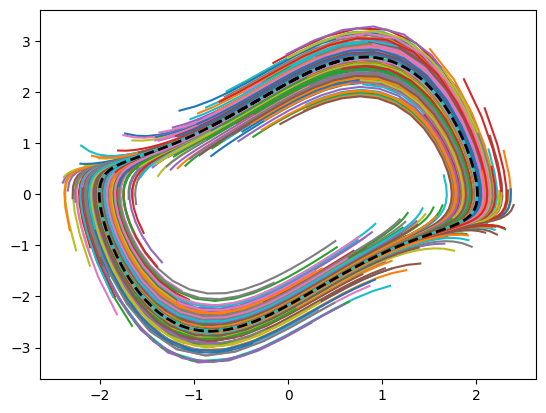

In [5]:
db = 0.4
smpl = {'x0': {
    'kind': 'perturb',
    'params': {'bounds': [-db, db], 'ref': _ref}}
    }
sampler = TrajectorySampler(f, g, config='sa_data.yaml', config_mod=smpl)
ts, xs, ys = sampler.sample(t_grid, batch=B, save='./data/sa.npz')

for i in range(B):
    plt.plot(ys[i, :, 0], ys[i, :, 1])
plt.plot(_ref[:,0], _ref[:,1], 'k--', linewidth=2);

## Model Definitions

As usual, start with a YAML file giving the basic configuration,

In [ ]:
"""
data:
  path: './data/sa.npz'
  n_samples: 500
  n_steps: 81
  double_precision: true

transform_x:
  type: "scaler"
  mode: "-11"

transform_u:
  type: "identity"

split:
  train_frac: 0.8

dataloader:
  batch_size: 400
"""

We will consider 5 model configurations in this example.  The first three are equivalent to the DMD formulation, lifting the states up to 9th order polynomials.  The differences are

- No truncation in the least squares step, so the model order is the same as the number of features.
- Standard DMD, that truncates the least squares to rank 15.
- The "ResDMD" approach, that computes a full least squares step, and truncates later by the so-called residual criteria.  See, e.g., [here](https://www.cambridge.org/core/journals/journal-of-fluid-mechanics/article/residual-dynamic-mode-decomposition-robust-and-verified-koopmanism/67F1513D7E0E182E8094ABCD3E5E94ED)

The above 3 configurations share the same model dictionary,

In [7]:
trans = [
        {"type": "scaler", "mode": "-11"},
        {"type": "lift", "fobs": "poly", "Ks": [10, 10]}  # New transformation in pre-processing
    ]
mdl_kl = {
    "name" : 'sa_model',
    "encoder_layers" : 0,         # No autoencoding, since already done by lifting
    "decoder_layers" : 0,
    "koopman_dimension" : 100,
    "activation" : "none",
    "weight_init" : "xavier_uniform",
    "predictor_type" : "exp",}    # Using matrix exponential for prediction, since the whole model is linear

The 3 configurations are all trained using the `ls_update` feature, which in this case is equivalent to the DMD algorithms.  The differences are in the options.

> SAKO stands for Spectral Analysis of Koopman Operator, where the core algorithms are from ResDMD.

In [8]:
ref = {
    "n_epochs": 1,
    "save_interval": 1,
    "load_checkpoint": False,}
trn_ln = {                        
    "ls_update": {
        "method": "full"}}        # No truncation at all
trn_ln.update(ref)
trn_tr = {
    "ls_update": {
        "method": "truncated",    # Truncation to rank 15
        "params": 15}}
trn_tr.update(ref)
trn_sa = {
    "ls_update": {
        "method": "sako",         # ResDMD, rank 15
        "params": 15,
        "remove_one": True}}      # Remove the trivial constant mode
trn_sa.update(ref)

The remaining two model configurations involve autoencoders, assuming a Koopman dimension of 3.  One is continuous-time, and the other is discrete-time.

Note in continuous-time, the `ls_update` uses a method `full_log`.  This means computing the discrete-time matrix first (by least-squares), and then taking the log of the matrix to recover the continuous-time matrix.  The approach is effective for datasets with lower sampling frequencies, but limited to the autonomous case.

In [9]:
mdl_kb = {
    "name" : 'sa_model',
    "encoder_layers" : 2,
    "decoder_layers" : 2,
    "latent_dimension" : 64,
    "koopman_dimension" : 3,
    "activation" : "prelu",
    "weight_init" : "xavier_uniform",
    "predictor_type" : "exp",}     # Matrix exponential used in the latent space

trn_dt = {
    "n_epochs": 5000,
    "save_interval": 100,
    "load_checkpoint": False,
    "learning_rate": 1e-2,
    "decay_rate": 0.999,
    "ls_update": {
        "method": "full",          # One ls_update to warm-start the training
        "interval": 500,
        "times": 1}
        }
trn_ct = copy.deepcopy(trn_dt)
trn_ct["ls_update"]["method"] = "full_log"

## Training and Prediction

First train the five configurations

In [10]:
config_path = 'sa_model.yaml'

cfgs = [
    ('dkbf_ln', DKBF, LinearTrainer,   {"model": mdl_kl, "transform_x" : trans, "training" : trn_ln}),
    ('dkbf_tr', DKBF, LinearTrainer,   {"model": mdl_kl, "transform_x" : trans, "training" : trn_tr}),
    ('dkbf_sa', DKBF, LinearTrainer,   {"model": mdl_kl, "transform_x" : trans, "training" : trn_sa}),
    ('kbf_nd',  KBF,  NODETrainer,     {"model": mdl_kb, "training" : trn_ct}),
    ('dkbf_nd', DKBF, NODETrainer,     {"model": mdl_kb, "training" : trn_dt}),
    ]

IDX = [0, 1, 2, 3, 4]
labels = [cfgs[i][0] for i in IDX]

> Ignore possible warnings below, that are due to Apple chips.

In [11]:
for i in IDX:
    mdl, MDL, Trainer, opt = cfgs[i]
    opt["model"]["name"] = f"sa_{mdl}"
    trainer = Trainer(config_path, MDL, config_mod=opt)
    trainer.train()

/Users/daninghuang/Repos/dymad-dev/src/dymad/training/ls_update.py:285: RuntimeWarning: divide by zero encountered in matmul
  avg_epoch_loss = np.linalg.norm(A @ W - b) / A.shape[0]
/Users/daninghuang/Repos/dymad-dev/src/dymad/training/ls_update.py:285: RuntimeWarning: overflow encountered in matmul
  avg_epoch_loss = np.linalg.norm(A @ W - b) / A.shape[0]
/Users/daninghuang/Repos/dymad-dev/src/dymad/training/ls_update.py:285: RuntimeWarning: invalid value encountered in matmul
  avg_epoch_loss = np.linalg.norm(A @ W - b) / A.shape[0]
/Users/daninghuang/Repos/dymad-dev/src/dymad/numerics/linalg.py:160: RuntimeWarning: divide by zero encountered in matmul
  _B = (_Ur.conj().T @ B) / _Sr.reshape(-1, 1)
/Users/daninghuang/Repos/dymad-dev/src/dymad/numerics/linalg.py:160: RuntimeWarning: overflow encountered in matmul
  _B = (_Ur.conj().T @ B) / _Sr.reshape(-1, 1)
/Users/daninghuang/Repos/dymad-dev/src/dymad/numerics/linalg.py:160: RuntimeWarning: invalid value encountered in matmul
  _B 

Then predict using one new trajectory to check the performance.  The full DMD (`dkbf_ln`) and the two autoencoder models (`dkbf_nd` and `kbf_nd`) perform well.  The truncated DMD (`dkbf_tr`) is far off, while ResDMD (`dkbf_sa`) is much better at the same rank.  A more detailed comparison among the models will be provided in the next part.

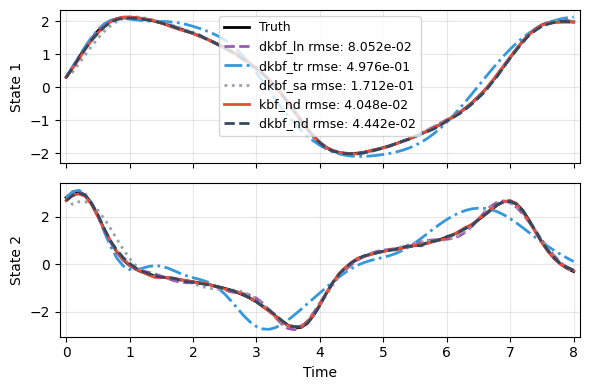

In [12]:
sampler = TrajectorySampler(f, g, config='sa_data.yaml', config_mod=smpl)
ts, xs, ys = sampler.sample(t_grid, batch=1)
x_data = xs[0]
t_data = ts[0]

res = [x_data]
for i in IDX:
    mdl, MDL, _, _ = cfgs[i]
    _, prd_func = load_model(MDL, f'sa_{mdl}.pt')
    with torch.no_grad():
        pred = prd_func(x_data, t_data)
    res.append(pred)

plot_trajectory(np.array(res), t_data, "SA", labels=['Truth'] + labels, ifclose=False);